## **Import the needed packages**

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, re
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.corpus import words
from sklearn.feature_extraction.text import CountVectorizer
import string
import keras
import tensorflow

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manderson\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manderson\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Load the dataset**

In [16]:
#-- The BBC dataset
news_data = pd.read_csv('articles.csv')

#-- let's look at some of the data
print("Number of rows : " + str(news_data.shape[0]))
news_data.sample(10)

Number of rows : 2225


,news,type
741,Singer Sizzla jailed for swearing\n \n Reggae ...,entertainment
1893,Halo 2 sells five million copies\n \n Microsof...,tech
709,Spears seeks aborted tour payment\n \n Singer ...,entertainment
1210,Blair 'up for it' ahead of poll\n \n Tony Blai...,politics
1915,Net fingerprints combat attacks\n \n Eighty la...,tech
167,Man Utd to open books to Glazer\n \n Mancheste...,business
1159,BAA support ahead of court battle\n \n UK airp...,politics
855,Director Nair's Vanity project\n \n Indian fil...,entertainment
593,De Niro film leads US box office\n \n Film sta...,entertainment
1001,Brown targets OAPs and homebuyers\n \n Gordon ...,politics


## **Clean our dataset**

In [17]:
# data cleaning
def clean_line(t):
    return (t.replace(' \n ',' ')
            .replace('\r',' ')
            .replace('\t',' ')
            .replace('  ',' ')
            .strip().lower())

#-- initialize the lemmatizer
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from nltk import tokenize

paras = []
labels = []
texts = []
for raw_doc in news_data['news']:
    text = clean_line(raw_doc)
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    paras.append(sentences)

## **TD-IDF Weight**

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

#-- function to create document term matrix
def createDTM(text):
    vect = TfidfVectorizer()
    dtm = vect.fit_transform(text)
    #-- create pandas dataframe of DTM
    return pd.DataFrame(dtm.toarray(), columns=vect.get_feature_names())

#-- let's take a look at the dtm
documents = createDTM(news_data['news'])
documents.sample(10)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
2165,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1579,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2104,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2084,0.0,0.021565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2195,0.0,0.013586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1704,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
709,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1867,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2044,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **GLoVe Embeddings**

In [19]:
WORD_SIZE = 300

embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.840B.300d.txt'), encoding='UTF-8')

for line in f:
    tokens = line.split(" ")
    if tokens:
        embeddings_index[tokens[0]] = np.asarray(tokens[1:WORD_SIZE + 1], dtype='float32')
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2196016 word vectors.


# **Preprocessng with Keras**

In [26]:
MAX_SENTENCE_NUM = 9
MAX_WORD_NUM = 40
MAX_FEATURES = 200000

tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token=True)
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

# create raw data by mapping each word to its embedding*tf-idf weighting
data = np.zeros((len(texts), MAX_SENTENCE_NUM, MAX_WORD_NUM, WORD_SIZE), dtype='float32')
for i, document in enumerate(paras):
    wordCount = 0
    for j, sentence in enumerate(document):
        if j < MAX_SENTENCE_NUM:
            words = text_to_word_sequence(sentence)
            for k, word in enumerate(words):
                wordCount += 1
                if k < MAX_WORD_NUM:
                    word_emedding = np.zeros((WORD_SIZE), dtype='float32')
                    if word in documents.columns and word in embeddings_index:
                        word_weight = documents[word].iloc[i] if word in documents.columns else 1
                        word_emedding = embeddings_index[word] * word_weight
                    data[i,j,k] = word_emedding

In [28]:
topics = pd.get_dummies(news_data['type'])
print('Shape of data tensor:', data.shape)
print('Shape of topics tensor:', topics.shape)

Shape of data tensor: (2225, 9, 40, 300)
Shape of topics tensor: (2225, 5)


In [79]:
# train-validation split
VALIDATION_SPLIT = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
topics = topics.iloc[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = topics[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = topics[-nb_validation_samples:]

actual_labels = topics.idxmax(axis = 1).map({'business': 0, 'entertainment': 1, 'politics': 2, 'sport' : 3, 'technology' : 4, 'tech': 5})

# **Attention Layer**

In [40]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K

class AttentionLayer(Layer):
    """
    Hierarchial Attention Layer as described by Hierarchical Attention Networks for Document Classification(2016)
    - Yang et. al.
    Source: https://www.cs.cmu.edu/~hovy/papers/16HLT-hierarchical-attention-networks.pdf
    Theano backend
    """
    def __init__(self,attention_dim=100,return_coefficients=False,**kwargs):
        # Initializer 
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform') # initializes values with uniform distribution
        self.attention_dim = attention_dim
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Builds all weights
        # W = Weight matrix, b = bias vector, u = context vector
        assert len(input_shape) == 3
        # casting "Dimension" type of input_shape's elements to "int" type
        #input_shape = tuple([i if (isinstance(i, float) or i is None else i.value for i in input_shape)])
        with tf.init_scope():
            self.W = K.variable(self.init((input_shape[-1], self.attention_dim)),name='W')
            self.b = K.variable(self.init((self.attention_dim, )),name='b')
            self.u = K.variable(self.init((self.attention_dim, 1)),name='u')
        self._trainable_weights = [self.W, self.b, self.u]

        super(AttentionLayer, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, hit, mask=None):
        # Here, the actual calculation is done
        uit = K.bias_add(K.dot(hit, self.W),self.b)
        uit = K.tanh(uit)
        
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        ait = K.exp(ait)
        
        if mask is not None:
            ait *= K.cast(mask, K.floatx())

        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = hit * ait
        
        if self.return_coefficients:
            return [K.sum(weighted_input, axis=1), ait]
        else:
            return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

# **Model**

In [80]:
import tensorflow.keras
from tensorflow.python.keras.layers import Embedding
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Bidirectional, GRU, Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras import initializers
from tensorflow.python.keras.layers import TimeDistributed
from tensorflow.python.keras.layers import Dropout

# Words level attention model
word_input = Input(shape=(MAX_WORD_NUM, WORD_SIZE, ), dtype='float32', name='word_input')
word_gru = Bidirectional(GRU(50, return_sequences=True),name='word_gru')(word_input)
word_dense = Dense(100, activation='relu', name='word_dense')(word_gru) 
word_att, word_coeffs = AttentionLayer(WORD_SIZE, True, name='word_attention')(word_dense)
wordEncoder = Model(inputs = word_input,outputs = word_att)


# Sentence level attention model
sent_input = Input(shape=(MAX_SENTENCE_NUM, MAX_WORD_NUM, WORD_SIZE), dtype='float32',name='sent_input')
print("sent_input ",sent_input)
sent_encoder = TimeDistributed(wordEncoder, name='sent_linking')(sent_input)
sent_gru = Bidirectional(GRU(50, return_sequences=True),name='sent_gru')(sent_encoder)
sent_dense  = Dense(100, activation='relu', name='sent_dense')(sent_gru) 
sent_att,sent_coeffs = AttentionLayer(EMBED_SIZE,return_coefficients=True,name='sent_attention')(sent_dense)
sent_drop = Dropout(0.5,name='sent_dropout')(sent_att)
preds = Dense(5, activation='softmax',name='output')(sent_drop)

# Model compile
model = Model(sent_input, preds)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
print(wordEncoder)
print("-------------------")
print(model.summary())

sent_input  Tensor("sent_input_1:0", shape=(None, 9, 40, 300), dtype=float32)
-------------------
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sent_input (InputLayer)      [(None, 9, 40, 300)]      0         
_________________________________________________________________
sent_linking (TimeDistribute (None, 9, 100)            146000    
_________________________________________________________________
sent_gru (Bidirectional)     (None, 9, 100)            45300     
_________________________________________________________________
sent_dense (Dense)           (None, 9, 100)            10100     
_________________________________________________________________
sent_attention (AttentionLay [(None, 100), (None, 9, 1 30600     
_________________________________________________________________
sent_dropout (Dropout)       (None, 100)               0         
___________________________

In [81]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=50, batch_size=400)

Train on 1780 samples, validate on 445 samples
Epoch 1/50
1780/1780 [==============================] - 31s 17ms/sample - loss: 1.6055 - acc: 0.2652 - val_loss: 1.5981 - val_acc: 0.2360
Epoch 2/50
1780/1780 [==============================] - 29s 16ms/sample - loss: 1.5925 - acc: 0.2618 - val_loss: 1.5762 - val_acc: 0.2337
Epoch 3/50
1780/1780 [==============================] - 25s 14ms/sample - loss: 1.5661 - acc: 0.2978 - val_loss: 1.5149 - val_acc: 0.4270
Epoch 4/50
1780/1780 [==============================] - 30s 17ms/sample - loss: 1.4675 - acc: 0.4764 - val_loss: 1.3099 - val_acc: 0.6247
Epoch 5/50
1780/1780 [==============================] - 35s 20ms/sample - loss: 1.2212 - acc: 0.5983 - val_loss: 0.9912 - val_acc: 0.6764
Epoch 6/50
1780/1780 [==============================] - 28s 16ms/sample - loss: 0.9810 - acc: 0.6663 - val_loss: 0.7660 - val_acc: 0.7708
Epoch 7/50
1780/1780 [==============================] - 28s 16ms/sample - loss: 0.8034 - acc: 0.7270 - val_loss: 0.6516 - val

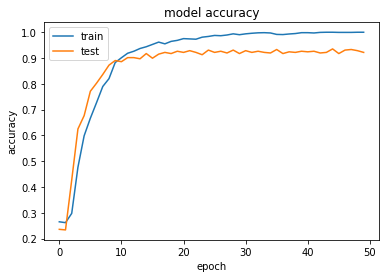

In [82]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

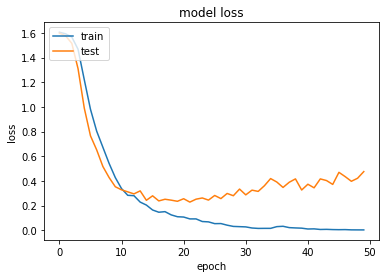

In [83]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Intermediate Layer

In [84]:
layer_name = 'sent_attention'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_layer_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer
intermediate_output, _ = intermediate_layer_model.predict(data)

## Clustering

In [91]:
from sklearn.cluster import KMeans, OPTICS
from sklearn.metrics.cluster import adjusted_rand_score
kmeans = KMeans(n_clusters=6, random_state=0).fit(intermediate_output)
clusters_preds = kmeans.labels_
print(adjusted_rand_score(actual_labels, clusters_preds))

optics = OPTICS().fit(intermediate_output)
clusters_preds = optics.labels_
print(adjusted_rand_score(actual_labels, clusters_preds))

0.8856175111546325
0.006441640132708015
